In [1]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.utils import np_utils
import numpy as np
import pandas as pd
from keras import initializers
from sklearn.model_selection import train_test_split
import requests
import datetime

def init_weights(shape, name=None):
    return initializers.normal(shape, scale=0.01, name=name)

Using TensorFlow backend.


In [4]:

API_ENDPOINT_URL =  'http://lauzhack.sqpub.ch/histo_prices'
r = requests.get(API_ENDPOINT_URL)
raw_data = r.text.split('\n')
data_series = pd.Series(raw_data)
data_series = data_series.str.split(' ')
data = pd.DataFrame(data_series.values.tolist(), index=data_series.index)
data.columns = ['timestamp', 'price']
data['timestamp'] = pd.to_datetime(data.timestamp)
time_stamps = data['timestamp']
data.set_index('timestamp', inplace=True)
data['price'] = data['price'].astype(float)
mean_minute = data.groupby(pd.Grouper(freq='60s')).mean()[2881:].dropna()
mean_minute


input_step_size = 50
output_size = 30
sliding_window = False

prices= data.loc[:,'price'].values
times = data.loc[:,'price'].values
prices.shape


# In[31]:


outputs = []
inputs = []
output_times = []
input_times = []
if sliding_window:
    for i in range(len(prices)-input_step_size-output_size):
        inputs.append(prices[i:i + input_step_size])
        input_times.append(times[i:i + input_step_size])
        outputs.append(prices[i + input_step_size: i + input_step_size+ output_size])
        output_times.append(times[i + input_step_size: i + input_step_size+ output_size])
else:
    for i in range(0,len(prices)-input_step_size-output_size, input_step_size):
        inputs.append(prices[i:i + input_step_size])
        input_times.append(times[i:i + input_step_size])
        outputs.append(prices[i + input_step_size: i + input_step_size+ output_size])
        output_times.append(times[i + input_step_size: i + input_step_size+ output_size])
inputs= np.array(inputs)
outputs= np.array(outputs)
output_times = np.array(output_times)
input_times = np.array(input_times)


ValueError: Length mismatch: Expected axis has 17 elements, new values have 2 elements

In [ ]:
import numpy as np
import pandas as pd
 
class PastSampler:
    '''
    Forms training samples for predicting future values from past value
    '''
     
    def __init__(self, N, K, sliding_window = True):
        '''
        Predict K future sample using N previous samples
        '''
        self.K = K
        self.N = N
        self.sliding_window = sliding_window
 
    def transform(self, A):
        M = self.N + self.K     #Number of samples per row (sample + target)
        #indexes
        if self.sliding_window:
            I = np.arange(M) + np.arange(A.shape[0] - M + 1).reshape(-1, 1)
        else:
            if A.shape[0]%M == 0:
                I = np.arange(M)+np.arange(0,A.shape[0],M).reshape(-1,1)
                
            else:
                I = np.arange(M)+np.arange(0,A.shape[0] -M,M).reshape(-1,1)
            
        B = A[I].reshape(-1, M * A.shape[1], A.shape[2])
        ci = self.N * A.shape[1]    #Number of features per sample
        return B[:, :ci], B[:, ci:] #Sample matrix, Target matrix



#Columns of price data to use
columns = ['price']
data = data.loc[:,columns]
original_data = data.loc[:,columns]

In [ ]:

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# normalization
for c in columns:
    data[c] = scaler.fit_transform(data[c].values.reshape(-1,1))
    
    
    
#Features are input sample dimensions(channels)
A = np.array(data)[:,None,:]
original_A = np.array(original_data)[:,None,:]
time_stamps = np.array(time_stamps)[:,None,None]

#Make samples of temporal sequences of pricing data (channel)
NPS, NFS = 256, 16         #Number of past and future samples
ps = PastSampler(NPS, NFS, sliding_window=False)
B, Y = ps.transform(A)
input_times, output_times = ps.transform(time_stamps)
original_B, original_Y = ps.transform(original_A)

file_name='bitcoin2015to2017_close.h5'

import h5py
with h5py.File(file_name, 'w') as f:
    f.create_dataset("inputs", data = B)
    f.create_dataset('outputs', data = Y)
    f.create_dataset("input_times", data = np.string_(input_times))
    f.create_dataset('output_times', data = np.string_(output_times))
    f.create_dataset("original_datas", data=np.array(original_data))
    f.create_dataset('original_inputs',data=original_B)
    f.create_dataset('original_outputs',data=original_Y)



In [ ]:
#CNN

import pandas as pd
import numpy as numpy
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, MaxPooling1D, LeakyReLU, PReLU
from keras.utils import np_utils
from keras.callbacks import CSVLogger, ModelCheckpoint
import h5py
import os
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session




with h5py.File(''.join(['bitcoin2015to2017_close.h5']), 'r') as hf:
    datas = hf['inputs'].value
    labels = hf['outputs'].value


output_file_name='bitcoin2015to2017_close_CNN_2_relu'

step_size = datas.shape[1]
batch_size= 8
nb_features = datas.shape[2]

epochs = 100

#split training validation
training_size = int(0.8* datas.shape[0])
training_datas = datas[:training_size,:]
training_labels = labels[:training_size,:]
validation_datas = datas[training_size:,:]
validation_labels = labels[training_size:,:]
#build model

# 2 layers
model = Sequential()


model.add(Conv1D(activation='relu', input_shape=(step_size, nb_features), strides=3, filters=8, kernel_size=20))
model.add(Dropout(0.5))
model.add(Conv1D( strides=4, filters=nb_features, kernel_size=16))

'''
# 3 Layers
model.add(Conv1D(activation='relu', input_shape=(step_size, nb_features), strides=3, filters=8, kernel_size=8))
#model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Conv1D(activation='relu', strides=2, filters=8, kernel_size=8))
#model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Conv1D( strides=2, filters=nb_features, kernel_size=8))
# 4 layers
model.add(Conv1D(activation='relu', input_shape=(step_size, nb_features), strides=2, filters=8, kernel_size=2))
#model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Conv1D(activation='relu', strides=2, filters=8, kernel_size=2))
#model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Conv1D(activation='relu', strides=2, filters=8, kernel_size=2))
#model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Conv1D( strides=2, filters=nb_features, kernel_size=2))
'''

model.compile(loss='mse', optimizer='adam')
model.fit(training_datas, training_labels,verbose=1, batch_size=batch_size,validation_data=(validation_datas,validation_labels), epochs = epochs, callbacks=[CSVLogger(output_file_name+'.csv', append=True),ModelCheckpoint('weights/'+output_file_name+'-{epoch:02d}-{val_loss:.5f}.hdf5', monitor='val_loss', verbose=1,mode='min')])

In [ ]:
#LSTM

import pandas as pd
import numpy as numpy
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,Reshape
from keras.layers import Conv1D, MaxPooling1D
from keras.utils import np_utils
from keras.layers import LSTM, LeakyReLU
from keras.callbacks import CSVLogger, ModelCheckpoint
import h5py
import os
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session




with h5py.File(''.join(['bitcoin2015to2017_close.h5']), 'r') as hf:
    datas = hf['inputs'].value
    labels = hf['outputs'].value




step_size = datas.shape[1]
units= 50
second_units = 30
batch_size = 8
nb_features = datas.shape[2]
epochs = 100
output_size=16
output_file_name='bitcoin2015to2017_close_LSTM_1_tanh_leaky_'
#split training validation
training_size = int(0.8* datas.shape[0])
training_datas = datas[:training_size,:]
training_labels = labels[:training_size,:,0]
validation_datas = datas[training_size:,:]
validation_labels = labels[training_size:,:,0]


#build model
model = Sequential()
model.add(LSTM(units=units,activation='tanh', input_shape=(step_size,nb_features),return_sequences=False))
model.add(Dropout(0.8))
model.add(Dense(output_size))
model.add(LeakyReLU())
model.compile(loss='mse', optimizer='adam')
model.fit(training_datas, training_labels, batch_size=batch_size,validation_data=(validation_datas,validation_labels), epochs = epochs, callbacks=[CSVLogger(output_file_name+'.csv', append=True),ModelCheckpoint('weights/'+output_file_name+'-{epoch:02d}-{val_loss:.5f}.hdf5', monitor='val_loss', verbose=1,mode='min')])

In [4]:
#Plot

from keras import applications
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.callbacks import CSVLogger
import tensorflow as tf
from scipy.ndimage import imread
import numpy as np
import random
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D, LeakyReLU
from keras import backend as K
import keras
from keras.callbacks import CSVLogger, ModelCheckpoint
from keras.backend.tensorflow_backend import set_session
from keras import optimizers
import h5py
from sklearn.preprocessing import MinMaxScaler
import os
import pandas as pd
# import matplotlib

import matplotlib.pyplot as plt

os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

with h5py.File(''.join(['bitcoin2015to2017_close.h5']), 'r') as hf:
    datas = hf['inputs'].value
    labels = hf['outputs'].value
    input_times = hf['input_times'].value
    output_times = hf['output_times'].value
    original_inputs = hf['original_inputs'].value
    original_outputs = hf['original_outputs'].value
    original_datas = hf['original_datas'].value
    

scaler=MinMaxScaler()
#split training validation
training_size = int(0.8* datas.shape[0])
training_datas = datas[:training_size,:,:]
training_labels = labels[:training_size,:,:]
validation_datas = datas[training_size:,:,:]
validation_labels = labels[training_size:,:,:]
validation_original_outputs = original_outputs[training_size:,:,:]
validation_original_inputs = original_inputs[training_size:,:,:]
validation_input_times = input_times[training_size:,:,:]
validation_output_times = output_times[training_size:,:,:]

ground_true = np.append(validation_original_inputs,validation_original_outputs, axis=1)
ground_true_times = np.append(validation_input_times,validation_output_times, axis=1)
step_size = datas.shape[1]
batch_size= 8
nb_features = datas.shape[2]

model = Sequential()

# 2 layers
model.add(Conv1D(activation='relu', input_shape=(step_size, nb_features), strides=3, filters=8, kernel_size=20))
# model.add(LeakyReLU())
model.add(Dropout(0.25))
model.add(Conv1D( strides=4, filters=nb_features, kernel_size=16))
model.load_weights('weights/bitcoin2015to2017_close_CNN_2_relu-44-0.00166.hdf5')
model.compile(loss='mse', optimizer='adam')

ImportError: cannot import name '_errors'

In [20]:
predicted = model.predict(validation_datas)
predicted_inverted = []

for i in range(original_datas.shape[1]):
    scaler.fit(original_datas[:,i].reshape(-1,1))
    predicted_inverted.append(scaler.inverse_transform(predicted[:,:,i]))
print(np.array(predicted_inverted).shape)
np.array(predicted_inverted)


(1, 6, 16)


array([[[4387.7324, 4391.661 , 4391.493 , 4391.531 , 4403.4883,
         4414.228 , 4413.0293, 4409.6016, 4410.5786, 4408.4287,
         4400.5503, 4402.6606, 4385.003 , 4376.9224, 4354.338 ,
         4325.2485],
        [4292.439 , 4273.023 , 4254.802 , 4212.082 , 4224.8833,
         4215.2905, 4221.876 , 4208.086 , 4217.8384, 4214.6953,
         4215.6147, 4220.285 , 4226.6943, 4230.9424, 4252.6787,
         4252.3003],
        [4183.519 , 4180.363 , 4166.0293, 4204.6147, 4191.1494,
         4217.465 , 4230.7666, 4237.156 , 4233.644 , 4237.6943,
         4246.475 , 4250.609 , 4271.6074, 4269.5786, 4271.4375,
         4261.0654],
        [4323.7046, 4332.5513, 4322.6875, 4327.2954, 4321.922 ,
         4320.782 , 4320.834 , 4304.1816, 4295.0103, 4295.416 ,
         4288.994 , 4291.255 , 4291.3657, 4285.8594, 4283.686 ,
         4272.065 ],
        [4273.9077, 4277.2495, 4277.231 , 4279.2236, 4286.922 ,
         4293.165 , 4285.9844, 4291.024 , 4280.53  , 4283.1064,
         4274.193 , 

In [26]:
import math
import matplotlib.pyplot as plt
#!python
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial

    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except(ValueError, msg):
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

In [27]:
predicted_inverted = [[[4387.7324, 4391.661 , 4391.493 , 4391.531 , 4403.4883,
         4414.228 , 4413.0293, 4409.6016, 4410.5786, 4408.4287,
         4400.5503, 4402.6606, 4385.003 , 4376.9224, 4354.338 ,
         4325.2485],
        [4292.439 , 4273.023 , 4254.802 , 4212.082 , 4224.8833,
         4215.2905, 4221.876 , 4208.086 , 4217.8384, 4214.6953,
         4215.6147, 4220.285 , 4226.6943, 4230.9424, 4252.6787,
         4252.3003],
        [4183.519 , 4180.363 , 4166.0293, 4204.6147, 4191.1494,
         4217.465 , 4230.7666, 4237.156 , 4233.644 , 4237.6943,
         4246.475 , 4250.609 , 4271.6074, 4269.5786, 4271.4375,
         4261.0654],
        [4323.7046, 4332.5513, 4322.6875, 4327.2954, 4321.922 ,
         4320.782 , 4320.834 , 4304.1816, 4295.0103, 4295.416 ,
         4288.994 , 4291.255 , 4291.3657, 4285.8594, 4283.686 ,
         4272.065 ],
        [4273.9077, 4277.2495, 4277.231 , 4279.2236, 4286.922 ,
         4293.165 , 4285.9844, 4291.024 , 4280.53  , 4283.1064,
         4274.193 , 4266.963 , 4262.2607, 4247.4614, 4242.7324,
         4239.003 ],
        [4249.595 , 4247.475 , 4247.628 , 4246.8687, 4252.947 ,
         4257.615 , 4251.8125, 4246.779 , 4245.8027, 4243.144 ,
         4242.6143, 4244.0874, 4248.173 , 4249.7993, 4259.1104,
         4266.1025]]]
predictedValues = np.array(predicted_inverted[0][0])
inputValues = np.array(predicted_inverted[0][3])
data = np.concatenate((inputValues,predictedValues), axis=0)

def findBuySell(y, window_size):
    #buy = -1
    #sell = -1
    buy = []
    sell = []
    ysg = savitzky_golay(y, window_size=window_size, order=(window_size - 2))
    # Check for local minima or local maxima after the midpoint (since it is the time when we can actually buy/sell)
    for i in range(math.ceil(y.size/2), y.size-1):
        if ysg[i-1] <= ysg[i]:
            if ysg[i+1] <= ysg[i]:
                # Local max check if it is larger then the previous local max
                #if (sell != -1):
                    #if ysg[i] > ysg[sell]:
                        #sell = i
                #else:
                    #sell = i
                sell.append(i)
            #Otherwise increasing -> do nothing
        else:
            if ysg[i+1] > ysg[i]:
                #Local minima
                #if (buy != -1):
                    #if (ysg[i] < ysg[buy]) :
                        #buy = i
                #else:
                    #buy = i
                buy.append(i)
            #Otherwise decreasing -> do nothing
                    
    return (buy, sell)

In [28]:
print(data)
print(findBuySell(data, 7))

[4323.7046 4332.5513 4322.6875 4327.2954 4321.922  4320.782  4320.834
 4304.1816 4295.0103 4295.416  4288.994  4291.255  4291.3657 4285.8594
 4283.686  4272.065  4387.7324 4391.661  4391.493  4391.531  4403.4883
 4414.228  4413.0293 4409.6016 4410.5786 4408.4287 4400.5503 4402.6606
 4385.003  4376.9224 4354.338  4325.2485]
([18, 23], [17, 21, 24])


In [29]:
def plotSmooth(y, window_size):
    (buy, sell) = findBuySell(y, window_size)
    print(buy, sell)
    ysg = savitzky_golay(y, window_size=window_size, order=(window_size - 2))
    plt.plot(y, label='Noisy signal')
    plt.plot(ysg, 'r', label='Filtered signal')
    #if (buy > -1):
    #    plt.plot([buy], [y[buy]], marker='x', markersize=10, color="green")
    if (buy):
        for i in buy:
            plt.plot([i], [y[i]], marker='x', markersize=10, color="green")
    #if (sell > -1):
    #    plt.plot([sell], [y[sell]], marker='o', markersize=10, color="yellow")
    if (sell):
        for j in sell:
            plt.plot([j], [y[j]], marker="o", markersize=10, color="yellow")
    plt.legend()
    plt.show()

[18, 23] [17, 21, 24]


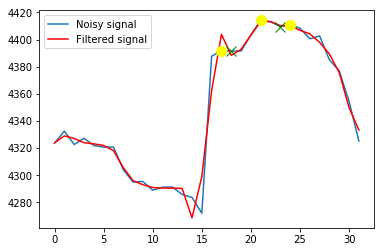

In [31]:
plotSmooth(data, 7)